In [2]:
!pip install -r requirements.txt

In [3]:
# importando as bibliotecas
import numpy as np
import pandas as pd
import random
from tqdm.auto import tqdm
import copy
import os
import multiprocessing
import itertools
import json
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import v_measure_score

In [4]:
# importando os modulos definidos
from src.Node import Node

In [5]:
random.seed(42)

# 1. Carregar e tratar os dados

In [6]:
def get_data(file_name, header):

    def read_csv_fle(file_name, header=0):
        train_data = pd.read_csv(f'./data/{file_name}train.csv', header=header)
        test_data = pd.read_csv(f'./data/{file_name}test.csv', header=header)
        return train_data, test_data
    
    train_data, test_data = read_csv_fle(file_name, header)

    train_labels = train_data.iloc[:, -1]
    train_features = train_data.iloc[:, :-1]

    test_labels = test_data.iloc[:, -1]
    test_features = test_data.iloc[:, :-1]

    def normalize(train_data, test_data):
        scaler = StandardScaler()
        scaler.fit(train_data)
        train_data = scaler.transform(train_data)
        test_data = scaler.transform(test_data)
        return train_data, test_data
    
    train_features, test_features = normalize(train_features, test_features)

    return train_features, train_labels, test_features, test_labels

# 2. Modelagem dos Indivíduo e População

Gera um idividuo modelado como uma árvore aleatória... usando o método grow.

Inicializa a população gerando uma lista de indivíduos aleatórios.

In [7]:
def generate_random_tree(max_depth: int, current_depth: int, terminals: list, variables:list) -> Node:

    if current_depth == max_depth-1 or (current_depth > 1 and random.random() > 0.5):
        value = random.choice(variables)
        return Node(value)
    else:
        op = random.choice(terminals)
        left_subtree = generate_random_tree(max_depth, current_depth + 1, terminals, variables)
        right_subtree = generate_random_tree(max_depth, current_depth + 1, terminals, variables)
        return Node(op, left_subtree, right_subtree)

In [8]:
def initialize_population_grow(pop_size:int, max_depth:int, terminals:list, variables:list) -> list:
    population = []
    for _ in range(pop_size):
        population.append(generate_random_tree(max_depth=max_depth, current_depth=0, terminals=terminals, variables=variables))

    return population

# 3. Cálculo do Fitness

Explciar cálculo da fitness através da matriz de distâncias, valor V e clusterização.

In [9]:
def evaluate_fitness(individual, differences, labels):
    safe_dict = {}
    safe_dict['operators'] = individual.operators
    safe_dict.update(differences)

    expression = individual.view_expression()

    distance_matrix = eval(expression, {"__builtins__": None}, safe_dict)

    num_clusters = len(np.unique(labels))
    clustering = AgglomerativeClustering(n_clusters=num_clusters, metric='precomputed', linkage='average')
    clustering.fit(distance_matrix)

    y_pred = clustering.labels_
    fitness = v_measure_score(labels, y_pred)

    return fitness

In [10]:
def compute_differences(features):
    X = pd.DataFrame(features, columns=[f'x{i}' for i in range(features.shape[1])])
    differences = {}
    for feature in X.columns:
        differences[feature] = X[feature].values[:, np.newaxis] - X[feature].values[np.newaxis, :]
    return differences

In [ ]:
def calculate_fitness_population(population, features, labels):
    fitness_scores = np.array([evaluate_fitness(ind, features, labels) for ind in population])
    return fitness_scores


# 4. Operadores Genéticos

explciar funcionamento do crossover

In [ ]:
def crossover(parent1: Node, parent2: Node) -> tuple:
    child1, child2 = copy.copy(parent1), copy.copy(parent2)
    
    nodes1 = child1.get_all_nodes()
    nodes2 = child2.get_all_nodes()
    
    crossover_point1 = random.choice(nodes1)
    crossover_point2 = random.choice(nodes2)
    
    crossover_point1.value, crossover_point2.value = crossover_point2.value, crossover_point1.value
    crossover_point1.left, crossover_point2.left = crossover_point2.left, crossover_point1.left
    crossover_point1.right, crossover_point2.right = crossover_point2.right, crossover_point1.right
    
    return child1, child2

explicar mutação

In [ ]:
def mutate(individual, terminals, variables, max_depth):
    mutant = copy.copy(individual)
        
    mutation_point = random.choice(mutant.get_all_nodes())
    new_subtree = generate_random_tree(max_depth, terminals, variables)

    mutation_point.value = new_subtree.value
    mutation_point.left = new_subtree.left
    mutation_point.right = new_subtree.right
    
    return mutant

explicar seleção por torneio

In [ ]:
def selection(population, fitness_scores, tournament_size=0):
    idx = np.random.choice(len(population), tournament_size)
    return population[idx[np.argmax(fitness_scores[idx])]]

# 5. Algoritmo de GP

explicar o algoritmo de GP

In [ ]:
def gp_algorithm(pop_size, max_depth, terminals, variables, generations, mutation_rate, crossover_rate, tournament_size, elitism, train_labels, test_labels, train_features, test_features):
    history = []
    best_fitness_train = 0
    population = initialize_population_grow(pop_size, max_depth, terminals, variables)
    differences = compute_differences(features)
    for generation in range(generations):
        # Parallel fitness calculation
        population_fitness = calculate_fitness_population(population, train_features, train_labels)
        best_individual = population[np.argmax(population_fitness)]
        best_fitness_train = max(best_fitness_train, max(population_fitness))
        history.append({
            'generation': generation,
            'best_fitness': max(population_fitness),
            'min_fitness': min(population_fitness),
            'average_fitness': np.mean(population_fitness)
        })
        new_population = [best_individual] if elitism else []
        while len(new_population) < pop_size:
            parent1, parent2 = selection(population, population_fitness, tournament_size), selection(population, population_fitness, tournament_size)
            child1, child2 = crossover(parent1, parent2) if random.random() < crossover_rate else (parent1, parent2)
            child1, child2 = mutate(child1, terminals, variables, max_depth//2), mutate(child2, terminals, variables, max_depth//2) if random.random() < mutation_rate else (child1, child2)
            new_population.extend([child1, child2])
        population = new_population[:pop_size]

    best_fitness_test = evaluate_fitness(best_individual, compute_differences(test_features), test_labels)
    return {
        'best_train_v_measure': best_fitness_train,
        'best_test_v_measure': best_fitness_test,
        'best_individual': best_individual.view_expression(),
        'history': history
    }

# 6. Experimentação

In [16]:
def save_result_as_csv(result):
    results_dir = 'results'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    
    filename = f"history_experiment_{result['experiment_id']}_rep_{result['repetition']}.json"
    filepath = os.path.join(results_dir, filename)
    
    with open(filepath, 'w') as f:
        json.dump(result, f, indent=4)
    

In [ ]:
def run_experiment(experiment_id, repetition, pop_size, max_depth, generations, mutation_rate, crossover_rate, tournament_size, elitism, config):

    terminals = ['+', '-', '*', '/']

    train_features, train_labels, test_features, test_labels = get_data('wineRed-', header=None)
    variables = [f'x{i}' for i in range(len(train_features[1]))]

    result = gp_algorithm(pop_size=pop_size, max_depth=max_depth, terminals=terminals, variables=variables, generations=generations, mutation_rate=mutation_rate, crossover_rate=crossover_rate, tournament_size=tournament_size, elitism=elitism, train_labels=train_labels, test_labels=test_labels, train_features=train_features, test_features=test_features)
    
    result['experiment_id'] = experiment_id
    result['repetition'] = repetition
    result['config'] = config
    
    result['history'] = result['history']

    save_result_as_csv(result)

In [18]:
def init_processes(tf, tl, tef, tel):
    global train_features, train_labels, test_features, test_labels
    train_features = tf
    train_labels = tl
    test_features = tef
    test_labels = tel

In [19]:
from multiprocessing.pool import Pool
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing.dummy import Pool as ThreadPool
import logging
import threading
from queue import Queue
import concurrent.futures
#from multiprocessing import Queue
import glob
from tqdm import tqdm

In [20]:
def run_experiment_safe(experiment_id, repetition, population_size, max_depth, num_generation, mutation_prob, 
                        crossover_prob, tournament_size, elitism):
    try:
        # Set up run_config within this function
        run_config = {
            'population_size': population_size,
            'num_generations': num_generation,
            'crossover_prob': crossover_prob,
            'mutation_prob': mutation_prob,
            'tournament_size': tournament_size,
            'experiment_id': experiment_id,
            'repetition': repetition
        }

        logging.info(f"Starting experiment {experiment_id}, repetition {repetition}")
        
        # Call the original function
        run_experiment(experiment_id, repetition, population_size, max_depth, 
                       num_generation, mutation_prob, crossover_prob, tournament_size, elitism, 
                       run_config)
        
        logging.info(f"Completed experiment {experiment_id}, repetition {repetition}")
    except Exception as e:
        logging.error(f"Error in experiment {experiment_id}, repetition {repetition}: {e}")

In [ ]:
def apply_in_thread_pool(
    num_threads, function, experiment_id, N_repetition, population_size, max_depth, num_generation, mutation_prob, 
                        crossover_prob, tournament_size, elitism
):
    repetitions = list(range(N_repetition))

    with ThreadPool(num_threads) as pool:
        result = pool.map(
            lambda repetition: function(experiment_id, repetition, population_size, max_depth, num_generation, mutation_prob, 
                        crossover_prob, tournament_size, elitism),
            repetitions,
            chunksize=10
        )
        assert len(result) == len(N_repetition)

In [22]:
def run_experiment_worker(progress_queue, experiment_id, repetition, population_size, max_depth, num_generation, mutation_prob, crossover_prob, tournament_size, elitism):
    run_experiment_safe(experiment_id, repetition, population_size, max_depth, num_generation, mutation_prob, crossover_prob, tournament_size, elitism)
    progress_queue.put(1)  # Marca progresso

def run_experiment_parallel(experiment_id, n_repetitions, population_size, max_depth, num_generation, mutation_prob, crossover_prob, tournament_size, elitism):
    progress_queue = Queue()

    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:  # Ajuste max_workers conforme necessário
        futures = [
            executor.submit(run_experiment_worker, progress_queue, experiment_id, rep, population_size, max_depth, num_generation, mutation_prob, crossover_prob, tournament_size, elitism)
            for rep in range(n_repetitions)
        ]

        for _ in tqdm(range(n_repetitions), desc="Progress"):
            progress_queue.get()  # Espera cada repetição completar

        # Aguarda todas as threads finalizarem
        concurrent.futures.wait(futures)

In [23]:
import glob

In [24]:
def test_population(config):
    pop_size = config['population_size']
    max_depth = config['max_individual_size']
    num_generations = config['num_generations']
    elitism = config['elitism']
    n_repetitions = config['n_repetitions']
    experiment_id = config['experiment_id']

    # Define parâmetros fixos para evitar repetição desnecessária
    crossover_prob = 0.9
    mutation_prob = 0.05
    tournament_size = 2

  # Verifica arquivos apenas uma vez

    for population_size in tqdm(pop_size, desc='Population Size'):
        for num_generation in tqdm(num_generations, desc='Number of Generations'):
            pattern = f'results/history_experiment_{experiment_id}*.json'
            if not glob.glob(pattern):
                apply_in_thread_pool(4, run_experiment_safe, experiment_id, n_repetitions, population_size, max_depth, num_generation, mutation_prob, crossover_prob, tournament_size, elitism)
            experiment_id += 1

# 7. Rodar Experimentos

In [25]:
# PARAMETROS DO ALGORITMO GENETICO

### FIXOS ###
TAMANHO_MAXIMO_INDIVIDUO = 7
ELITISMO = True
REPETICOES = 10
TERMINAIS = ['+', '-', '*', '/']

### VARIÁVEIS ###
TAMAHO_POPULACAO = [30, 50, 100, 500]
NUMERO_GERACOES = [30, 50, 100, 500]
K_TORNEIO = [2,3,5,7]
PROB_OPERADORES = [
        {'CROSSOVER': 0.9, 'MUTATION': 0.05},
        {'CROSSOVER': 0.6, 'MUTATION': 0.3},
    ]

# PARAMETROS DO DATASET
WINE_FILE_NAME = 'wineRed-'
BREAST_CANCER_FILE_NAME = 'breast_cancer_coimbra_'

In [26]:
import os
os.cpu_count()

12

### 7.1 Teste População

In [27]:
experiment_id = 1

config = {
    'population_size': TAMAHO_POPULACAO,
    'max_individual_size': TAMANHO_MAXIMO_INDIVIDUO,
    'num_generations': NUMERO_GERACOES,
    'elitism': ELITISMO,
    'n_repetitions': REPETICOES,
    'experiment_id': experiment_id
}

test_population(config)

Population Size:   0%|          | 0/4 [00:00<?, ?it/s]


TypeError: 'int' object is not iterable

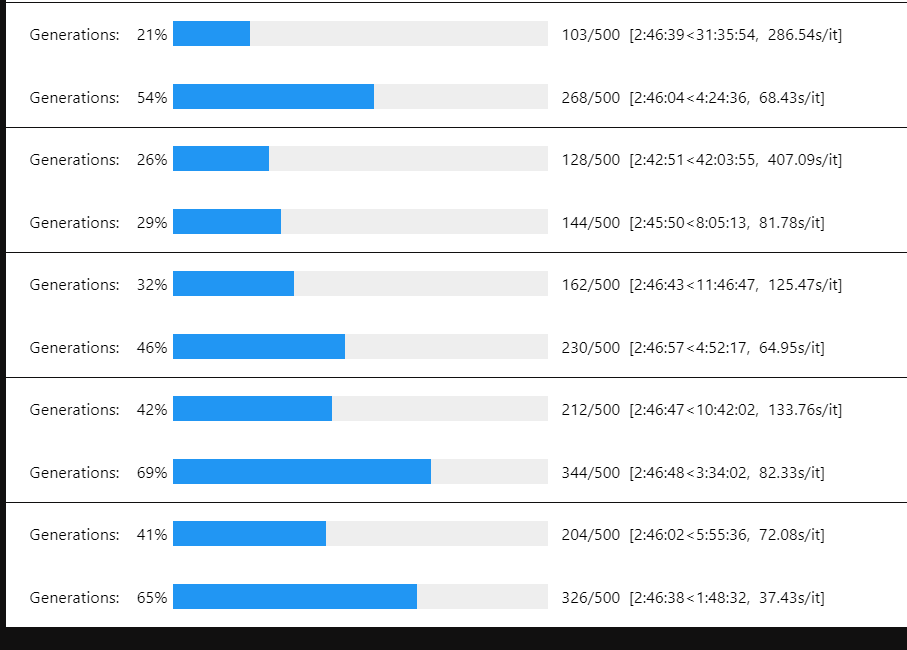